In [1]:
import pandas as pd
import numpy as np
import sklearn.ensemble
import sklearn.neural_network
import sklearn.svm
import sklearn.naive_bayes
import sklearn.tree
import lime.lime_tabular_mod
import matplotlib.pyplot as plt
import doc.mod.utils.DatasetRepository as dr
from tqdm import tqdm

import importlib
importlib.reload(lime.lime_tabular_mod)
repo = dr.DatasetRepository("../data")


pd.set_option("display.max_columns", None)
pd.set_option("mode.chained_assignment", None)
plt.style.use({"figure.facecolor": "white"})

### Load dataset: Wines

In [2]:
dataset = repo.get_wines_dataset()
dataset.train_data

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
1333,9.1,0.775,0.22,2.2,0.079,12.0,48.0,0.99760,3.18,0.51,9.6
958,6.4,0.570,0.12,2.3,0.120,25.0,36.0,0.99519,3.47,0.71,11.3
732,7.3,0.835,0.03,2.1,0.092,10.0,19.0,0.99660,3.39,0.47,9.6
284,9.9,0.590,0.07,3.4,0.102,32.0,71.0,1.00015,3.31,0.71,9.8
1157,5.1,0.510,0.18,2.1,0.042,16.0,101.0,0.99240,3.46,0.87,12.9
...,...,...,...,...,...,...,...,...,...,...,...
1302,9.1,0.370,0.32,2.1,0.064,4.0,15.0,0.99576,3.30,0.80,11.2
203,7.0,0.420,0.35,1.6,0.088,16.0,39.0,0.99610,3.34,0.55,9.2
666,8.3,0.490,0.36,1.8,0.222,6.0,16.0,0.99800,3.18,0.60,9.5
1037,7.3,0.910,0.10,1.8,0.074,20.0,56.0,0.99672,3.35,0.56,9.2


## Check performance of different classifiers on selected dataset (with their default settings)

In [3]:
models = [
    ("Random Forest", sklearn.ensemble.RandomForestClassifier(n_jobs=-1)),
    ("AdaBoost", sklearn.ensemble.AdaBoostClassifier()),
    ("DecisionTree", sklearn.tree.DecisionTreeClassifier()),
    ("Neural Network", sklearn.neural_network.MLPClassifier()),
    ("SVM", sklearn.svm.LinearSVC()),
    ("Naive Bayes", sklearn.naive_bayes.GaussianNB()),
    ("kNN", sklearn.neighbors.KNeighborsClassifier())
]
precision_for_classifier = {}
recall_for_classifier = {}
f1_for_classifier = {}
for (classifier_name, model) in models:
    x = dataset.train_data.to_numpy()
    y = dataset.train_labels.to_numpy()
    model.fit(x, y)

    x = dataset.test_data.to_numpy()
    y_true = dataset.test_labels.to_numpy()
    y_predicted = model.predict(x)

    precision_for_classifier[classifier_name] = sklearn.metrics.precision_score(y_true=y_true, y_pred=y_predicted, average="macro")
    recall_for_classifier[classifier_name] = sklearn.metrics.recall_score(y_true=y_true, y_pred=y_predicted, average="macro")
    f1_for_classifier[classifier_name] = sklearn.metrics.f1_score(y_true=y_true, y_pred=y_predicted, average="macro")

c:\users\kamil zych\documents\mgr\lime\venv\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\kamil zych\documents\mgr\lime\venv\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\kamil zych\documents\mgr\lime\venv\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\kamil zych\documents\mgr\lim

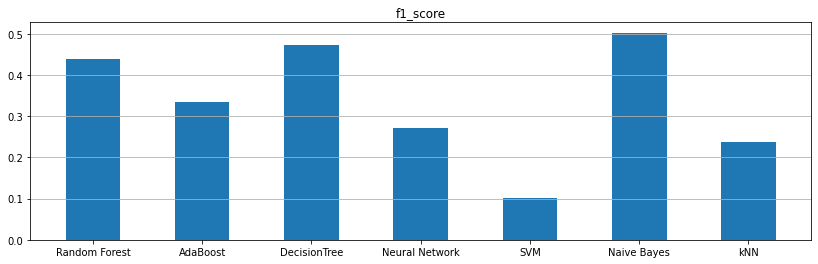

In [4]:
plt.figure(figsize=(14,4))
plt.bar(f1_for_classifier.keys(), f1_for_classifier.values(), width=0.5)
plt.title("f1_score")
plt.grid(axis="y")
plt.show()

## Use LIME to explain prediction
### Create explainer object
At first create explainer object that makes use of training data.
It may be used by discretizer inner object and enhance local surrogate's performance.

In [5]:
explainer = lime.lime_tabular_mod.LimeTabularExplainerMod(
    dataset.train_data.to_numpy(),
    feature_names = dataset.train_data.columns.to_list(),
    class_names = dataset.train_labels.drop_duplicates().to_list(), # should be equal to model.classes_
    discretize_continuous=False,
    sample_around_instance=True,
    categorical_features=dataset.categorical_features
)

In [7]:
test_data_subset = dataset.test_data.to_numpy()

labels_count = 6
quantiles_count = 50
test_instances_count = test_data_subset.shape[0]

scores_for_surrogate_model = np.empty(shape=(test_instances_count, labels_count), dtype="float32")
losses_for_surrogate_model = np.empty(shape=(test_instances_count, labels_count), dtype="float32")
fidelity_loss_on_explanation = np.empty(shape=(test_instances_count,), dtype="float32")
fidelity_loss_on_generated_data = np.empty(shape=(test_instances_count,), dtype="float32")
fidelity_loss_distribution_quantiles = np.empty(shape=(test_instances_count, quantiles_count), dtype="float32")

for idx, test_instance in enumerate(tqdm(test_data_subset)):
    explanation = explainer.explain_instance(
        test_instance.reshape(-1),
        model.predict_proba,
        num_features = 4,
        top_labels = labels_count,
        distance_metric="minkowski",
        minkowski_norm=100.
    )
    scores_for_surrogate_model[idx, :] = explanation.get_scores_for_surrogate_model()
    losses_for_surrogate_model[idx, :] = explanation.get_losses_for_surrogate_model()
    fidelity_loss_on_explanation[idx] = explanation.get_fidelity_loss_on_explanation()
    fidelity_loss_on_generated_data[idx] = explanation.get_fidelity_loss_on_generated_data()
    fidelity_loss_distribution_quantiles[idx, :] = explanation.get_fidelity_loss_distribution(quantiles=quantiles_count)

100%|██████████| 160/160 [01:12<00:00,  2.20it/s]


label #0 mean score: 0.014539572410285473
label #1 mean score: 0.1046806126832962
label #2 mean score: 0.24763230979442596
label #3 mean score: 0.1451636552810669
label #4 mean score: 0.08425919711589813
label #5 mean score: 0.017113858833909035


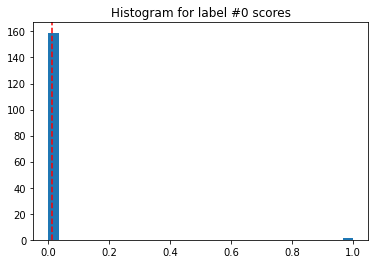

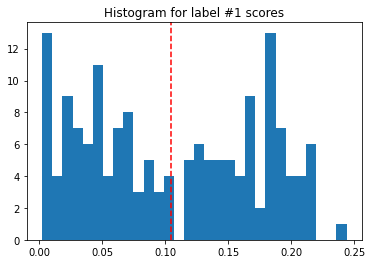

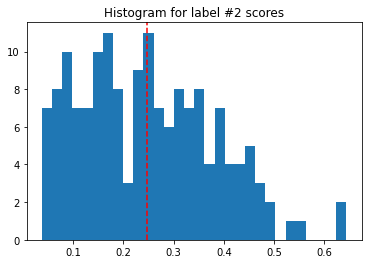

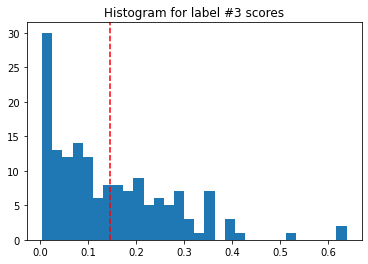

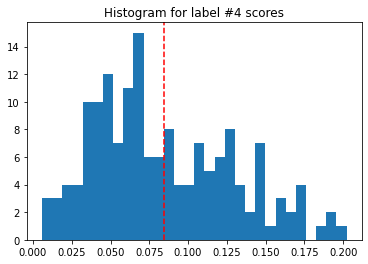

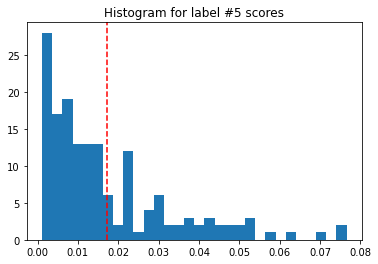

In [8]:
for idx in range(labels_count):
    mean_score = np.mean(scores_for_surrogate_model[:, idx])
    print(f"label #{idx} mean score: {mean_score}", flush=True)
    plt.hist(scores_for_surrogate_model[:, idx], bins=30)
    plt.axvline(mean_score, color="red", linestyle="--")
    plt.title(f"Histogram for label #{idx} scores")
    plt.show()

label #0 mean loss: 0.00046495386050082743
label #1 mean loss: 0.007180807646363974
label #2 mean loss: 0.05740548297762871
label #3 mean loss: 0.0529048815369606
label #4 mean loss: 0.01971101388335228
label #5 mean loss: 0.0012166243977844715


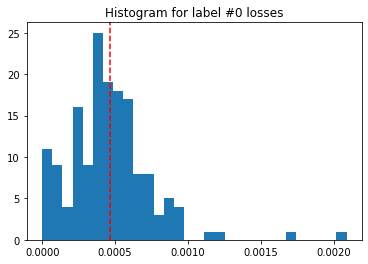

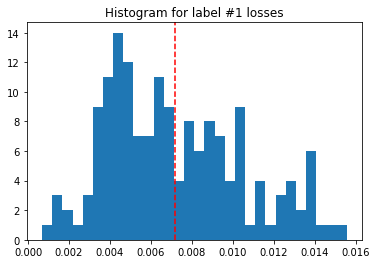

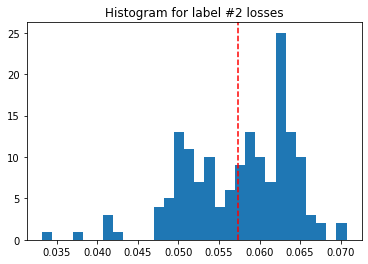

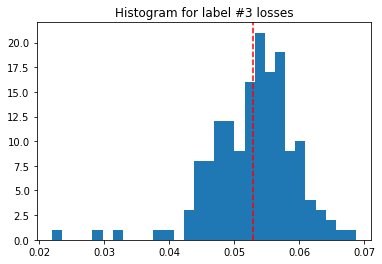

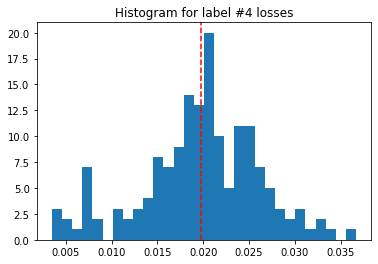

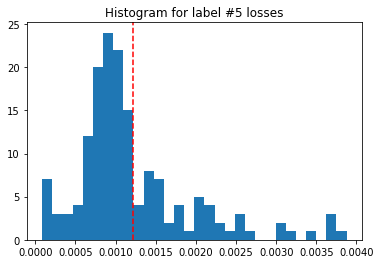

In [9]:
for idx in range(labels_count):
    mean_loss = np.mean(losses_for_surrogate_model[:, idx])
    print(f"label #{idx} mean loss: {mean_loss}")
    plt.hist(losses_for_surrogate_model[:, idx], bins=30)
    plt.axvline(mean_loss, color="red", linestyle="--")
    plt.title(f"Histogram for label #{idx} losses")
    plt.show()

Mean fidelity loss on explanation: 0.05639612674713135


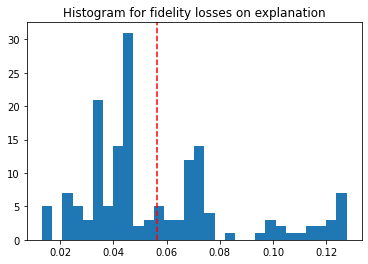

In [10]:
mean_fidelity_loss_on_explanation = np.mean(fidelity_loss_on_explanation)
print(f"Mean fidelity loss on explanation: {mean_fidelity_loss_on_explanation}")
plt.hist(fidelity_loss_on_explanation, bins=30)
plt.axvline(mean_fidelity_loss_on_explanation, color="red", linestyle="--")
plt.title(f"Histogram for fidelity losses on explanation")
plt.show()

Mean fidelity loss on generated data: 0.052970029413700104


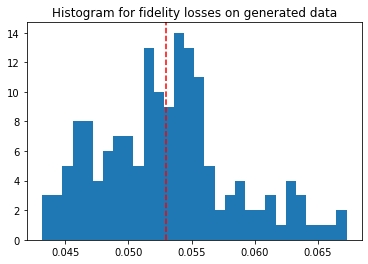

In [11]:
mean_fidelity_loss_on_generated_data = np.mean(fidelity_loss_on_generated_data)
print(f"Mean fidelity loss on generated data: {mean_fidelity_loss_on_generated_data}")
plt.hist(fidelity_loss_on_generated_data, bins=30)
plt.axvline(mean_fidelity_loss_on_generated_data, color="red", linestyle="--")
plt.title(f"Histogram for fidelity losses on generated data")
plt.show()

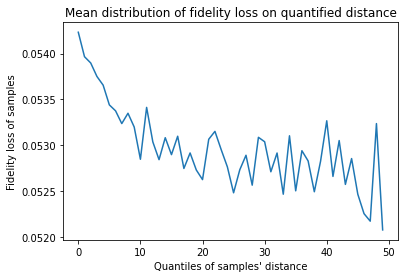

In [12]:
plt.plot(np.mean(fidelity_loss_distribution_quantiles, axis=0))
plt.ylabel(f"Fidelity loss of samples")
plt.xlabel(f"Quantiles of samples' distance")
plt.title(f"Mean distribution of fidelity loss on quantified distance")
plt.show()